# spiketorch Demo

In which we test some basic functionality in the [__spiketorch__](https://github.com/djsaunde/spiketorch) spiking neural networks (SNNs) Python library.

__Author__: [Dan Saunders](https://djsaunde.github.io)

## Background

The __spiketorch__ library allows one to simulate simple SNNs while making use of the powerful and flexible `torch.Tensor` object, and run on compatible GPU hardware (pending some recently introduced backwards-compatibility breaking bugs) for considerable speedups on large networks. It is meant to be used in the development of machine learning algorithms in the [Biologically Inspired Neural and Dynamical Systems lab](http://binds.cs.umass.edu/), supported by [DARPA](https://www.darpa.mil/) grant number DARPA-HR0011-16-l-0006, under the project titled *Superior Artificial Intelligence (AI)*.

__spiketorch__ currently supports the simulation of `Network`s of [leaky integrate-and-fire (LIF) neurons](http://icwww.epfl.ch/~gerstner/SPNM/node26.html) in groups of one or more (by objects `LIFGroup` and modification `AdaptiveLIFGroup`). To simulate such simple models, we only need to track neuron membrane potential, or voltage (recorded by vectors $\mathbf{v}$), and the occurrence and mechanism of [action potential](https://en.wikipedia.org/wiki/Action_potential) generation, or spiking (recorded by vectors $\mathbf{s}$).

__Note__: The `AdaptiveLIFGroup` has another state variable, $\theta$, which represents an adaptive neuron membrane potential, updated each time the neuron fires, but this modification isn't typical of the LIF neuron model. It was introduced in a [previous paper](https://www.frontiersin.org/articles/10.3389/fncom.2015.00099/full#) as a mechanism of *homeostasis*; that is, ensuring that all neurons have appromixately the same firing rate.

Neuron voltage dynamics $\mathbf{v}$ are defined to exponentially decay towards a value $v_{\textrm{rest}}$ in the absence of input. The `InputGroup` class of neurons do not have internal dynamics; rather, their input are fixed by the user. 

We say that a neuron *spikes* or *fires* when its membrane potential $v$ crosses a critical value, $\mathcal{v}$, the *threshold potential*. We record this as a entry of $1$ in the corresponding entry of spike vector $\mathbf{s}$ and reset the membrane potential to a *reset potential* $v_{\textrm{reset}}$, and these spikes may be used in downstream processing, if the neurons that emitted them are connected to other neurons.

Connections between neurons are handled via the `Synapse` and `STDPSynapse` objects. In both cases, one must specify the `source` and `target` groups of neurons, and optionally a connection matrix `w`; otherwise, a weight matrix of values with entries sampled from $\textrm{Uniform(0, 1)}$ is used. In the case of `STDPSynapse`s, other parameters governing pre- and post-synaptic learning rates, maximal weight values, and weight normalization can be specified, and weights are adapted via a simple [online STDP learning rule](http://www.scholarpedia.org/article/Spike-timing_dependent_plasticity).

As may be intuited, SNN simulations necessarily take place *in time*. The programmer can specify network initial conditions, parameters, and inputs over a simulation episode, and then call the `Network.run(mode, input, time)` function to simulate the SNN for `time` steps. If `mode='train'`, `STDPSynapse` weights and `AdaptiveLIFGroup` $\theta$ parameters are adapted at every simulation step; otherwise (`mode='test'`), they are held fixed, possibly loaded from disk at the start of a testing phase. At the end of a `Network.run()` call, a dictionary of spike times per neuron population is returned, useful for visualization or network activity-dependent control in other parts of the program.

## Imports and setup

In [1]:
from spiketorch.network import Network
from spiketorch.groups import *
from spiketorch.synapses import *

import os
import torch
import numpy as np
import pickle as p
import matplotlib.pyplot as plt

from scipy.stats import entropy
from mpl_toolkits.axes_grid1 import ImageGrid

%matplotlib inline

## Building a simple network

Let's create a network composed of randomly spiking input neurons connected to a group of otherwise unconnected neurons, and record their spiking activity. Connection weights from input to non-input neurons are samples from the unit Gaussian, $\mathcal{N}(0, 1)$.

We'll run the SNN simulation for 500 timesteps (corresponding to about 1ms), with 100 input and 100 excitatory neurons, respectively. Each input neuron will fire with probability $\frac{1}{20}$ at each timestep, corresponding to a frequency of $\approx \frac{1000\textrm{ms}}{20} = 50\textrm{Hz}$.

In [2]:
timesteps = 500
n_inpt = 100
n_excitatory = 100

p_fire = 0.05

In [3]:
network = Network(dt=1)  # timestep of 1ms

# Neuron groups.
network.add_group(InputGroup(n_inpt), 'input')
network.add_group(LIFGroup(n_excitatory), 'population')

# Synaptic connections.
w = torch.randn(n_inpt, n_excitatory)
network.add_synapses(Synapses(network.groups['input'], network.groups['population'],
                                                w=w), name=('input', 'population'))

# Create random inputs for `timesteps`.
inpt = np.random.binomial(2, p_fire, size=[timesteps, n_inpt])
inpt = torch.from_numpy(inpt)
inpts = {'input' : inpt}

Looking at the input to non-input synaptic strengths, they look Gaussian-distributed as specified, with approximately mean zero and standard deviation 1. Each row represents the connection strengths from one input neurons to all non-input neurons.

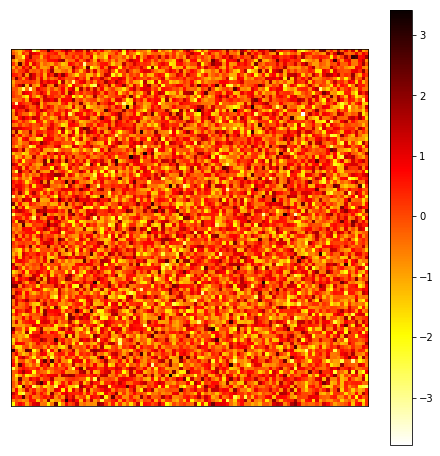

In [4]:
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.matshow(w.numpy(), cmap='hot_r')
plt.xticks(()); plt.yticks(())
plt.colorbar(im); plt.show()

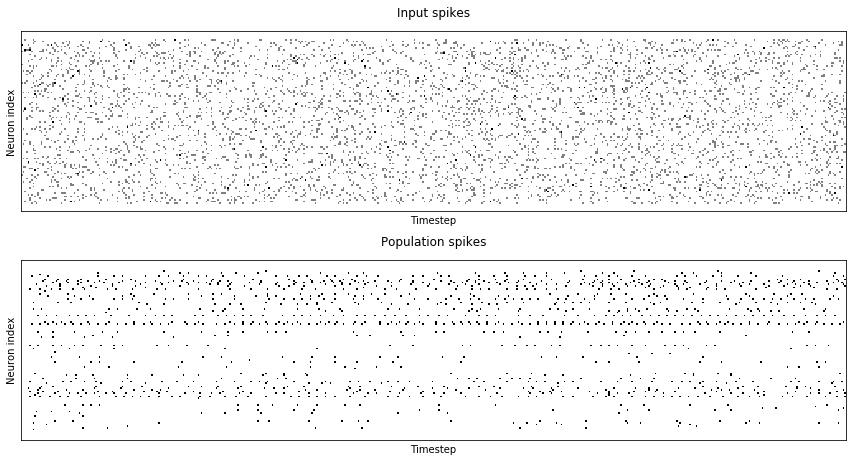

In [5]:
# Run the network for `timesteps`.
output = network.run(mode='test', inpts=inpts, time=timesteps)

fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True, figsize=(12, 6.5))

ax1.matshow(output['input'].numpy().T, cmap='binary')
ax2.matshow(output['population'].numpy().T, cmap='binary')

ax1.set_xticks(()); ax1.set_yticks(())
ax2.set_xticks(()); ax2.set_yticks(())
ax1.set_title('Input spikes'); ax2.set_title('Population spikes')
ax1.set_ylabel('Neuron index'); ax2.set_ylabel('Neuron index')
ax1.set_xlabel('Timestep'); ax2.set_xlabel('Timestep')

plt.tight_layout(); plt.show()

Plotting the input and non-input spiking activity, we notice that each input neuron indeeds spikes approximately 1 out of every 20 timesteps. This is due to our setting the firing probability `p_fire = 0.05`. Neurons in the non-input population are driven according to the input; however, since the connectivity is random uniform, it is difficult to guess which input neurons are driving which non-input neurons to fire.

Given the relative infrequency of spiking of the non-input population to the input population, it's clear that several spikes impinging on a neuron in a short time window are required to generate a spike. [This is an important feature of biological neurons](http://neuronaldynamics.epfl.ch/online/Ch1.S2.html)!

Let's add some connectivity in the non-input population of neurons. Namely, we'll connect each neuron to all other neurons with a synapse weight sampled from the unit Gaussian, $\mathcal{N} (0, 1)$.

In [6]:
network = Network(dt=1)  # timestep of 1ms

# Neuron groups.
network.add_group(InputGroup(n_inpt), 'input')
network.add_group(LIFGroup(n_excitatory), 'population')

# Synaptic connections.
w = torch.randn(n_inpt, n_excitatory)
network.add_synapses(Synapses(network.groups['input'], network.groups['population'],
                                                w=w), name=('input', 'population'))

w = torch.randn(n_excitatory, n_excitatory)
network.add_synapses(Synapses(network.groups['population'], network.groups['population'],
                                                w=w), name=('population', 'population'))

# Create random inputs for `timesteps`.
inpt = np.random.binomial(2, p_fire, size=[timesteps, n_inpt])
inpt = torch.from_numpy(inpt)
inpts = {'input' : inpt}

# Run the network for `timesteps`.
output = network.run(mode='test', inpts=inpts, time=timesteps)

Interestingly, adding this recurrent connectivity doesn't appear to qualitatively change the non-input population spiking behavior much.

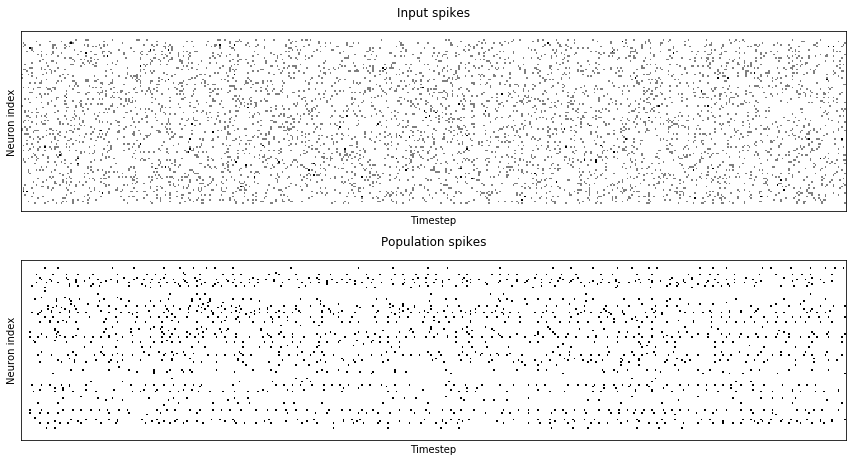

In [7]:
fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True, figsize=(12, 6.5))

ax1.matshow(output['input'].numpy().T, cmap='binary')
ax2.matshow(output['population'].numpy().T, cmap='binary')

ax1.set_xticks(()); ax1.set_yticks(())
ax2.set_xticks(()); ax2.set_yticks(())
ax1.set_title('Input spikes'); ax2.set_title('Population spikes')
ax1.set_ylabel('Neuron index'); ax2.set_ylabel('Neuron index')
ax1.set_xlabel('Timestep'); ax2.set_xlabel('Timestep')

plt.tight_layout(); plt.show()

Let's try some more interesting structure. Instead of random connectivity in the non-input population, why not have neurons inhibit each other more with increasing inter-neuron distance?

In [8]:
inhib = 2.5  # Controls strength of inter-neuron inhibition

network = Network(dt=1)

# Neuron groups.
network.add_group(InputGroup(n_inpt), 'input')
network.add_group(LIFGroup(n_excitatory), 'population')

# Synaptic connections.
w = torch.randn(n_inpt, n_excitatory)
network.add_synapses(Synapses(network.groups['input'], network.groups['population'],
                                                w=w), name=('input', 'population'))
w = -np.array([[inhib * np.sqrt(np.linalg.norm(idx1 - idx2)) for idx2 in \
            range(n_excitatory)] for idx1 in range(n_excitatory)])
w = torch.from_numpy(w).float()
network.add_synapses(Synapses(network.groups['population'], network.groups['population'],
                                                w=w), name=('population', 'population'))

# Create random inputs for `timesteps`.
inpt = np.random.binomial(2, p_fire, size=[timesteps, n_inpt])
inpt = torch.from_numpy(inpt)
inpts = {'input' : inpt}

# Run the network for `timesteps`.
output = network.run(mode='test', inpts=inpts, time=timesteps)

Due to increasing inhibition with inter-neuron distance, after an initial transient, most spiking activity in the non-input population is localized in a small neighborhood of neurons. The constant `inhib` in the above code block controls this effect; try changing it to see what happens.

In the limit of `inhib = 0`, we recover the first SNN model from above. As `inhib` increases, eventually we arrive to a point where only one neuron can fire at a time; this neuron has precluded all other neurons from firing by inhibiting it greatly.

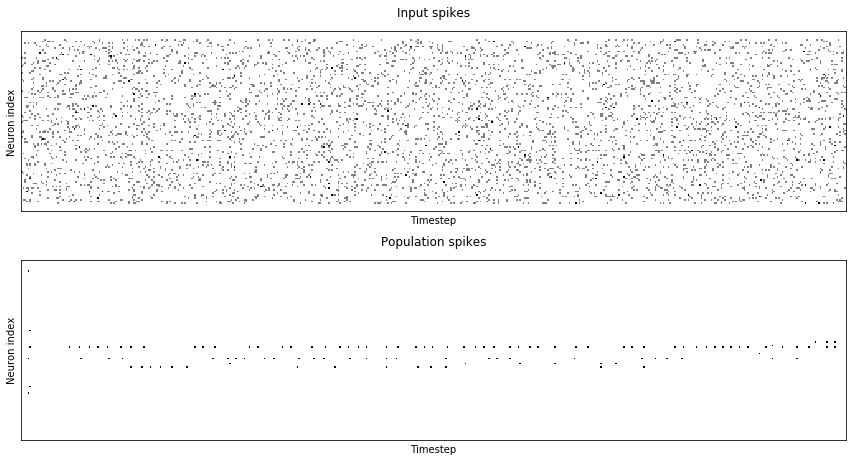

In [9]:
fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True, figsize=(12, 6.5))

ax1.matshow(output['input'].numpy().T, cmap='binary')
ax2.matshow(output['population'].numpy().T, cmap='binary')

ax1.set_xticks(()); ax1.set_yticks(())
ax2.set_xticks(()); ax2.set_yticks(())
ax1.set_title('Input spikes'); ax2.set_title('Population spikes')
ax1.set_ylabel('Neuron index'); ax2.set_ylabel('Neuron index')
ax1.set_xlabel('Timestep'); ax2.set_xlabel('Timestep')

plt.tight_layout(); plt.show()

Take a look at the weights: along the main diagonal, no neuron inhibits itself. On the other hand, distal neurons are inhibited more as inter-neuron distance increases.

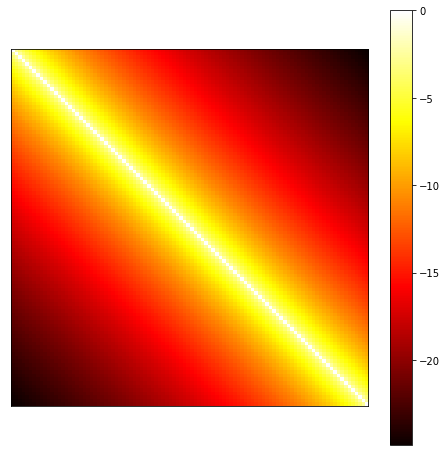

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.matshow(w.numpy(), cmap='hot')
plt.xticks(()); plt.yticks(())
plt.colorbar(im); plt.show()

Now, we can make the firing probability of the input neurons decrease with their index. For example, let's make the first neuron fire with probability $\sqrt{1}$, the second with probability $\sqrt{\frac{1}{2}}$, the third with probability $\sqrt{\frac{1}{3}}$, and so on. We'll connect the input to the non-input population in a one-to-one fashion, meaning that the first input neuron will connect only to the first non-input neuron, and so one. This should invoke a _graded firing response_ in the non-input population. Below some threshold of firing probability, neurons will be unable to fire, since they will _never receive enough consistent input to exceed their threshold_. 

In [11]:
timesteps = 500; n_inpt = 100; n_excitatory = 100; p_fire = 0.05

network = Network(dt=1)  # timestep of 1ms

# Neuron groups.
network.add_group(InputGroup(n_inpt), 'input')
network.add_group(LIFGroup(n_excitatory), 'population')

# Synaptic connections.
w = torch.ones(n_inpt).diag()
network.add_synapses(Synapses(network.groups['input'], network.groups['population'],
                                                w=w), name=('input', 'population'))

# Create random inputs for `timesteps`.
inpt = np.zeros([timesteps, n_inpt])
for idx in range(n_inpt):
    inpt[:, idx] = np.random.binomial(1, 1 / np.sqrt(idx + 1), size=[timesteps])

inpt = torch.from_numpy(inpt)
inpts = {'input' : inpt}

# Run the network for `timesteps`.
output = network.run(mode='test', inpts=inpts, time=timesteps)

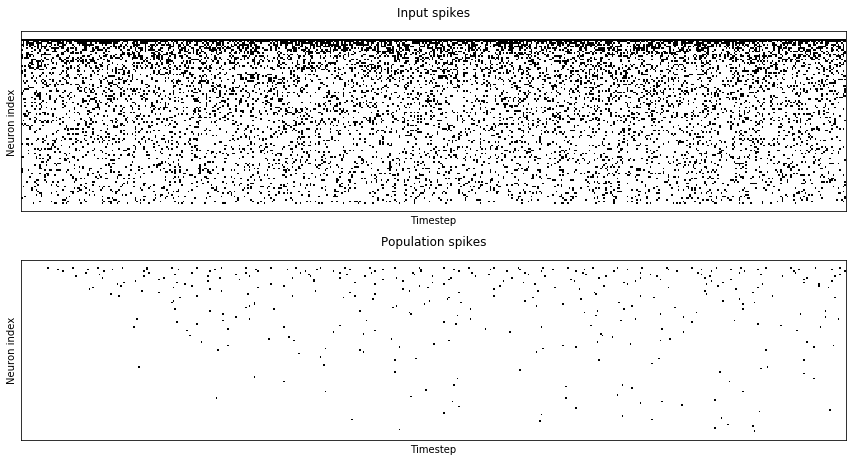

In [12]:
fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True, figsize=(12, 6.5))

ax1.matshow(output['input'].numpy().T, cmap='binary')
ax2.matshow(output['population'].numpy().T, cmap='binary')

ax1.set_xticks(()); ax1.set_yticks(())
ax2.set_xticks(()); ax2.set_yticks(())
ax1.set_title('Input spikes'); ax2.set_title('Population spikes')
ax1.set_ylabel('Neuron index'); ax2.set_ylabel('Neuron index')
ax1.set_xlabel('Timestep'); ax2.set_xlabel('Timestep')

plt.tight_layout(); plt.show()

Let's try something a little more complex. Suppose we want a simple network to learn a __representation__ of some data. For example, say we are interested in a small subset of the [MNIST handwritten digit dataset](http://yann.lecun.com/exdb/mnist/), in which there is only a single class of digits.

We can use the `STDPSynapses` class and the `train` mode of the network simulation to learn such a representation. In particular, we want to store a kind of _filter_ on the weights from input to non-input population which are fitted to the data of interest. In a network with many non-input neurons, having filters corresponding to different data classes should allow us to distinguish the input data simple by recording and observing network spiking activity.

In the setup below, we will use `n_images` from the digit class `label` to train a filter for a single non-input neuron.

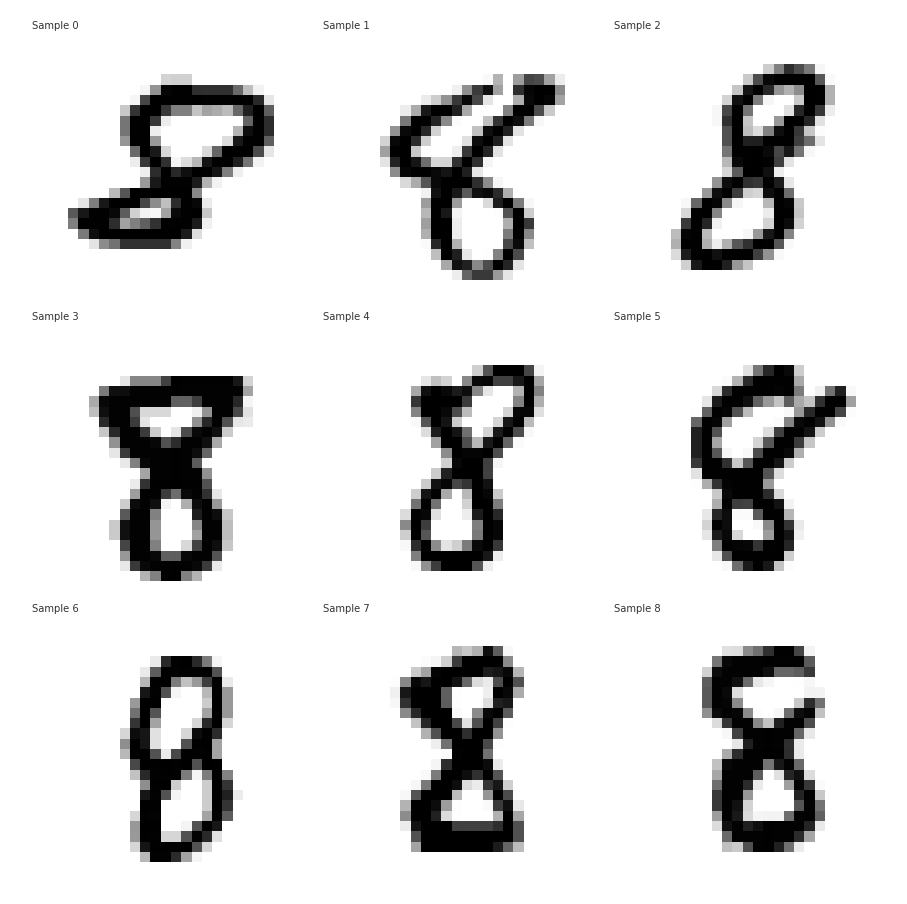

In [13]:
n_images = 9; im_sqrt = int(np.sqrt(n_images)); label = 8

data = p.load(open(os.path.join('..', 'data', 'test.p'), 'rb'))

images = []
for _ in range(n_images):
    idx = 0
    while len(images) < n_images:
        if data['y'][idx] == label:
            images.append(data['X'][idx])
            idx += 1
        else:
            idx += 1

fig = plt.figure(1, figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(im_sqrt, im_sqrt), axes_pad=0.05)
for idx in range(len(images)):
    ax = grid[idx]
    ax.matshow(images[idx].reshape([28, 28]), cmap='binary')
    ax.axis('off')
    ax.text(0, 0, 'Sample %d' % idx, color='k', backgroundcolor='w', alpha=0.8)

Now, we build the network. We can choose the number of `iterations` (number of times a different input is _presented_ to the network), the number of `timesteps` per iteration, and `n_inpt` and `n_excitatory` are as described above.

Input to non-input weights are initialized from a $\textrm{Uniform} (0, 0.1)$ distribution, the default behavior for the `spiketorch.synapses.STDPSynapses` object. After each iteration, synapse weights are collectively _normalized_ so that they grow too much; the amount of weight allotted to the synapses is described by the `norm` parameter passed into the `STDPSynapses` constructor. This parameter also implicitly controls the upper bound of the aforementioned uniform distribution.

In [14]:
iterations = 100; iter_sqrt = int(np.sqrt(iterations));  # Iterations of learning episodes
timesteps = 100  # No. of simulation timesteps
n_inpt = 784  # No. of input neurons (same as input dimensionality)
n_excitatory = 1  # No. of non-input neurons

network = Network(dt=1)  # timestep of 1ms

image = data['X'][1]

# Neuron groups (use synaptic traces to perform STDP).
network.add_group(InputGroup(n_inpt, traces=True), 'input')
network.add_group(LIFGroup(n_excitatory, traces=True), 'population')

# Synaptic connections (STDPSynapses have modifiable weights).
network.add_synapses(STDPSynapses(network.groups['input'],
    network.groups['population'], norm=100.0), name=('input', 'population'))

# Run the network for `iterations`, each with `timesteps`.
weights = []
for idx in range(iterations):
    # Use handwritten digit images for input.
    inpt = np.zeros([timesteps, n_inpt])
    image = images[idx % n_images].ravel() / 255.0
    
    for idx in range(n_inpt):
        inpt[:, idx] = np.random.binomial(1, image[idx], size=[timesteps])

    inpt = torch.from_numpy(inpt)
    inpts = {'input' : inpt}
    
    # Simulate network for `timesteps`
    network.run(mode='train', inpts=inpts, time=timesteps)
    weights.append(network.synapses[('input', 'population')].get_weights().numpy())

Here is a visualizaton of the progression of the single non-input neuron's incoming synapse weights over the `n_iterations` of training. As you can see, the weights at initialization are small and seemingly random; however, after a few training iterations, the neuron quickly adapts its filter to capture the essence of the learned digit.

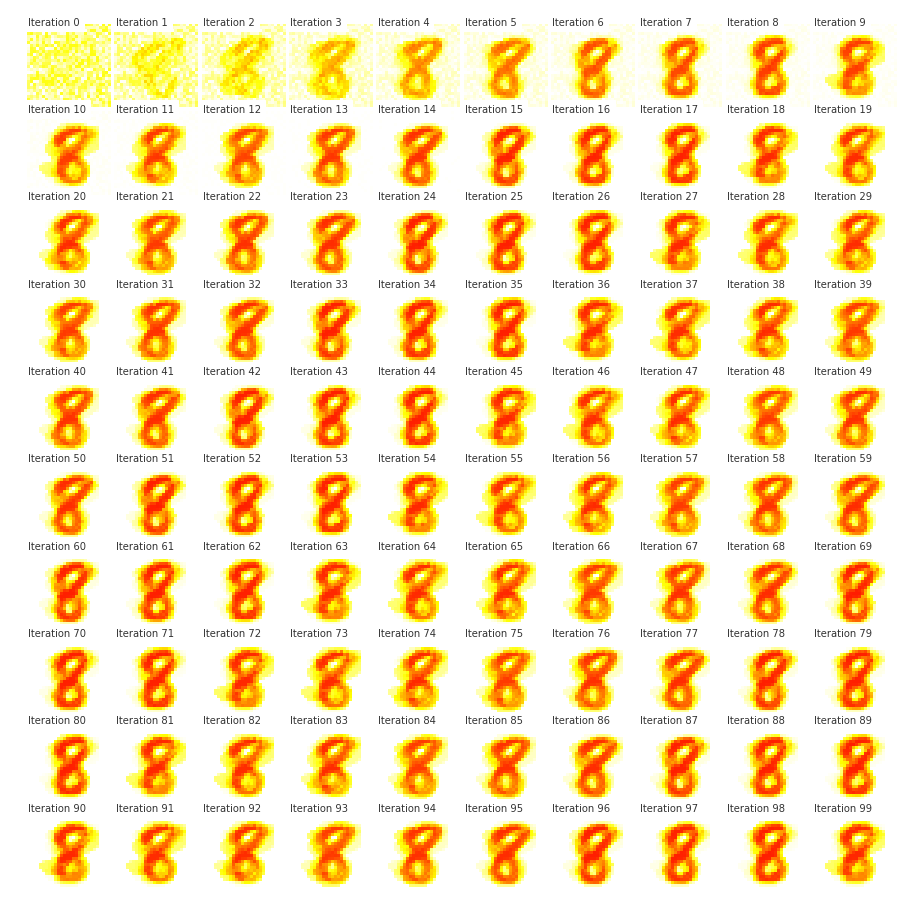

In [15]:
fig = plt.figure(1, figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(iter_sqrt, iter_sqrt), axes_pad=0.05)
for idx in range(len(weights)):
    ax = grid[idx]
    ax.matshow(weights[idx].reshape([28, 28]), cmap='hot_r', vmin=0, vmax=1)
    ax.axis('off')
    
    ax.text(0, 0, 'Iteration %d' % idx, color='k', backgroundcolor='w', alpha=0.8)

What is the __best__ representation learned from training on the `n_images` digit examples? This is a rather subjective question, and so, rather than answering it definitively, I'll provide a simple (likely inadequate) answer: the one with the least [__entropy__](https://en.wikipedia.org/wiki/Entropy_(information_theory))!

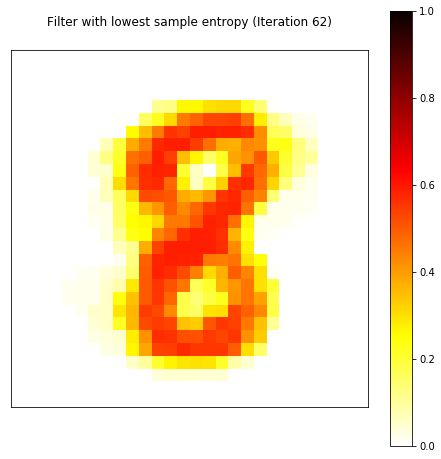

In [16]:
best_idx = np.argmin([entropy(weight) for weight in weights])
best = weights[best_idx].reshape([28, 28])
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.matshow(best, vmin=0, vmax=1, cmap='hot_r')
plt.colorbar(im); plt.title('Filter with lowest sample entropy (Iteration %d)' % best_idx);
plt.xticks(()); plt.yticks(()); plt.show()

More examples!

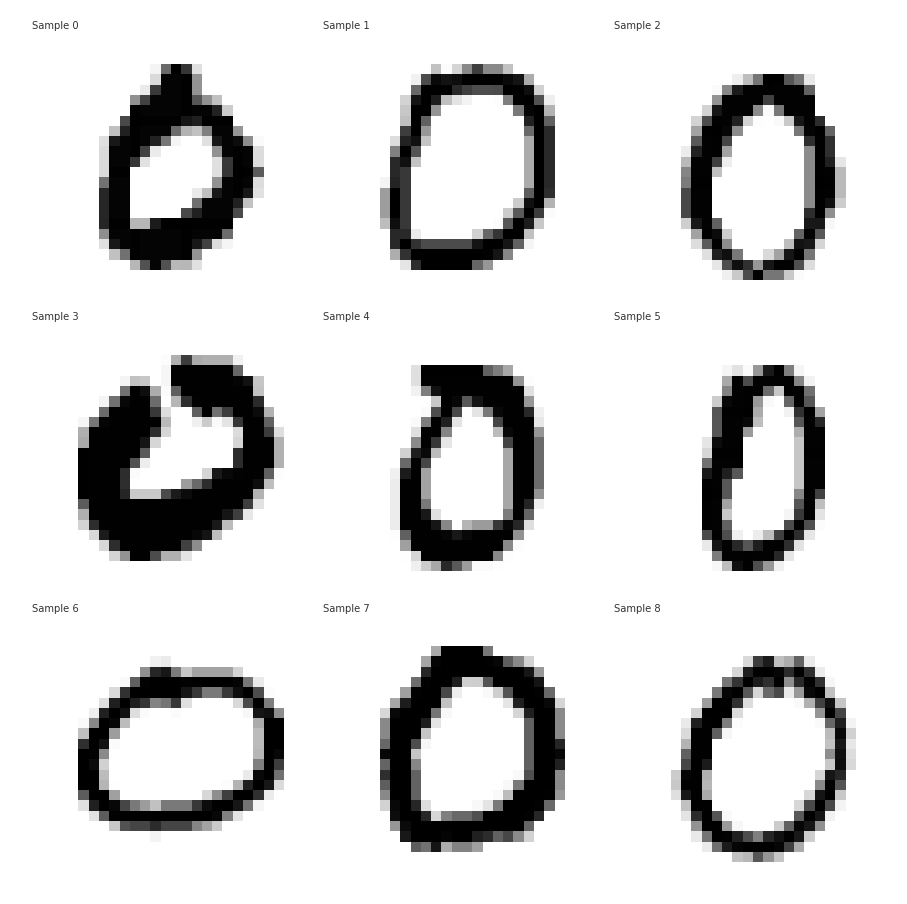

In [17]:
n_images = 9; im_sqrt = int(np.sqrt(n_images)); label = 0

data = p.load(open(os.path.join('..', 'data', 'test.p'), 'rb'))

images = []
for _ in range(n_images):
    idx = 0
    while len(images) < n_images:
        if data['y'][idx] == label:
            images.append(data['X'][idx])
            idx += 1
        else:
            idx += 1

fig = plt.figure(1, figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(im_sqrt, im_sqrt), axes_pad=0.05)
for idx in range(len(images)):
    ax = grid[idx]
    ax.matshow(images[idx].reshape([28, 28]), cmap='binary')
    ax.axis('off')
    ax.text(0, 0, 'Sample %d' % idx, color='k', backgroundcolor='w', alpha=0.8)

In [18]:
iterations = 100; iter_sqrt = int(np.sqrt(iterations));  # Iterations of learning episodes
timesteps = 100  # No. of simulation timesteps
n_inpt = 784  # No. of input neurons (same as input dimensionality)
n_excitatory = 1  # No. of non-input neurons

network = Network(dt=1)  # timestep of 1ms

image = data['X'][1]

# Neuron groups (use synaptic traces to perform STDP).
network.add_group(InputGroup(n_inpt, traces=True), 'input')
network.add_group(LIFGroup(n_excitatory, traces=True), 'population')

# Synaptic connections (STDPSynapses have modifiable weights).
network.add_synapses(STDPSynapses(network.groups['input'],
    network.groups['population'], norm=100.0), name=('input', 'population'))

# Run the network for `iterations`, each with `timesteps`.
weights = []
for idx in range(iterations):
    # Use handwritten digit images for input.
    inpt = np.zeros([timesteps, n_inpt])
    image = images[idx % n_images].ravel() / 255.0
    
    for idx in range(n_inpt):
        inpt[:, idx] = np.random.binomial(1, image[idx], size=[timesteps])

    inpt = torch.from_numpy(inpt)
    inpts = {'input' : inpt}
    
    # Simulate network for `timesteps`
    network.run(mode='train', inpts=inpts, time=timesteps)
    weights.append(network.synapses[('input', 'population')].get_weights().numpy())

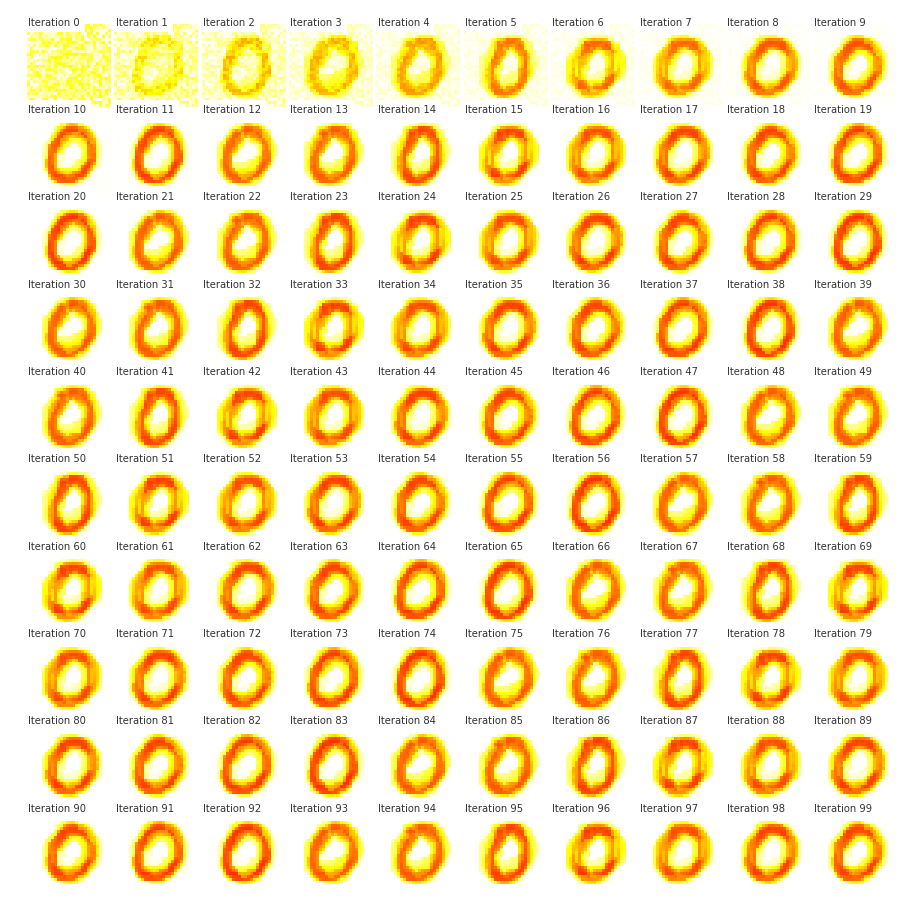

In [19]:
fig = plt.figure(1, figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(iter_sqrt, iter_sqrt), axes_pad=0.05)
for idx in range(len(weights)):
    ax = grid[idx]
    ax.matshow(weights[idx].reshape([28, 28]), cmap='hot_r', vmin=0, vmax=1)
    ax.axis('off')
    
    ax.text(0, 0, 'Iteration %d' % idx, color='k', backgroundcolor='w', alpha=0.8)

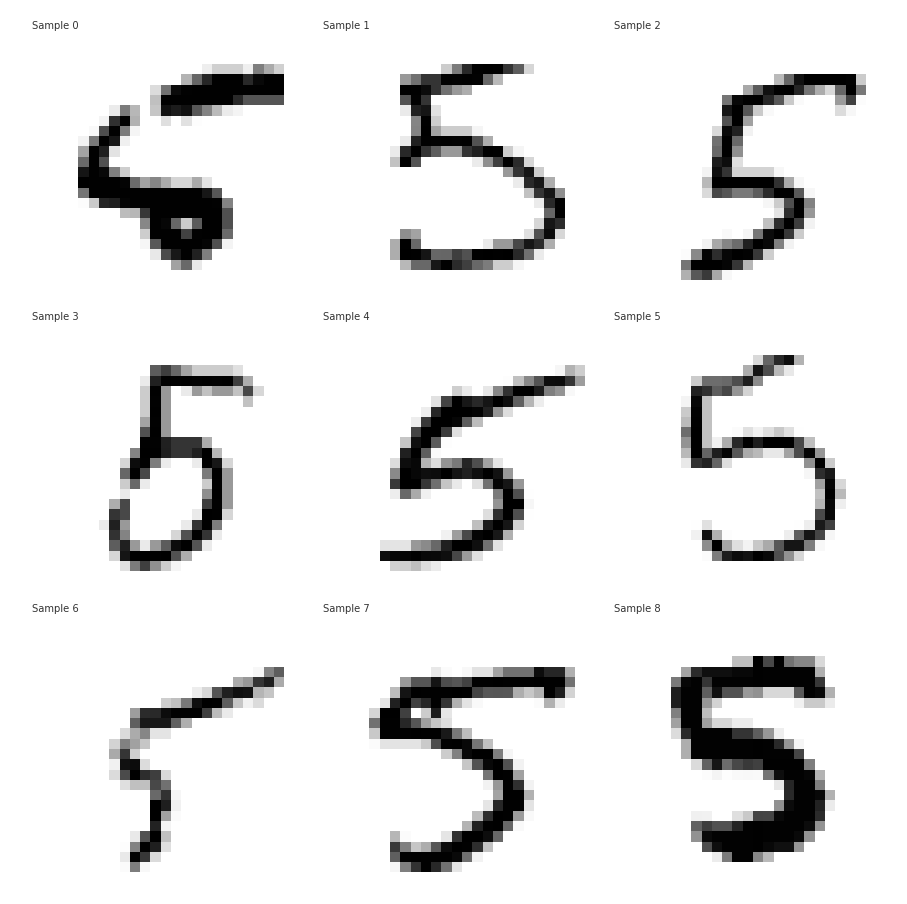

In [20]:
n_images = 9; im_sqrt = int(np.sqrt(n_images)); label = 5

data = p.load(open(os.path.join('..', 'data', 'test.p'), 'rb'))

images = []
for _ in range(n_images):
    idx = 0
    while len(images) < n_images:
        if data['y'][idx] == label:
            images.append(data['X'][idx])
            idx += 1
        else:
            idx += 1

fig = plt.figure(1, figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(im_sqrt, im_sqrt), axes_pad=0.05)
for idx in range(len(images)):
    ax = grid[idx]
    ax.matshow(images[idx].reshape([28, 28]), cmap='binary')
    ax.axis('off')
    ax.text(0, 0, 'Sample %d' % idx, color='k', backgroundcolor='w', alpha=0.8)

In [21]:
iterations = 100; iter_sqrt = int(np.sqrt(iterations));  # Iterations of learning episodes
timesteps = 100  # No. of simulation timesteps
n_inpt = 784  # No. of input neurons (same as input dimensionality)
n_excitatory = 1  # No. of non-input neurons

network = Network(dt=1)  # timestep of 1ms

image = data['X'][1]

# Neuron groups (use synaptic traces to perform STDP).
network.add_group(InputGroup(n_inpt, traces=True), 'input')
network.add_group(LIFGroup(n_excitatory, traces=True), 'population')

# Synaptic connections (STDPSynapses have modifiable weights).
network.add_synapses(STDPSynapses(network.groups['input'],
    network.groups['population'], norm=100.0), name=('input', 'population'))

# Run the network for `iterations`, each with `timesteps`.
weights = []
for idx in range(iterations):
    # Use handwritten digit images for input.
    inpt = np.zeros([timesteps, n_inpt])
    image = images[idx % n_images].ravel() / 255.0
    
    for idx in range(n_inpt):
        inpt[:, idx] = np.random.binomial(1, image[idx], size=[timesteps])

    inpt = torch.from_numpy(inpt)
    inpts = {'input' : inpt}
    
    # Simulate network for `timesteps`
    network.run(mode='train', inpts=inpts, time=timesteps)
    weights.append(network.synapses[('input', 'population')].get_weights().numpy())

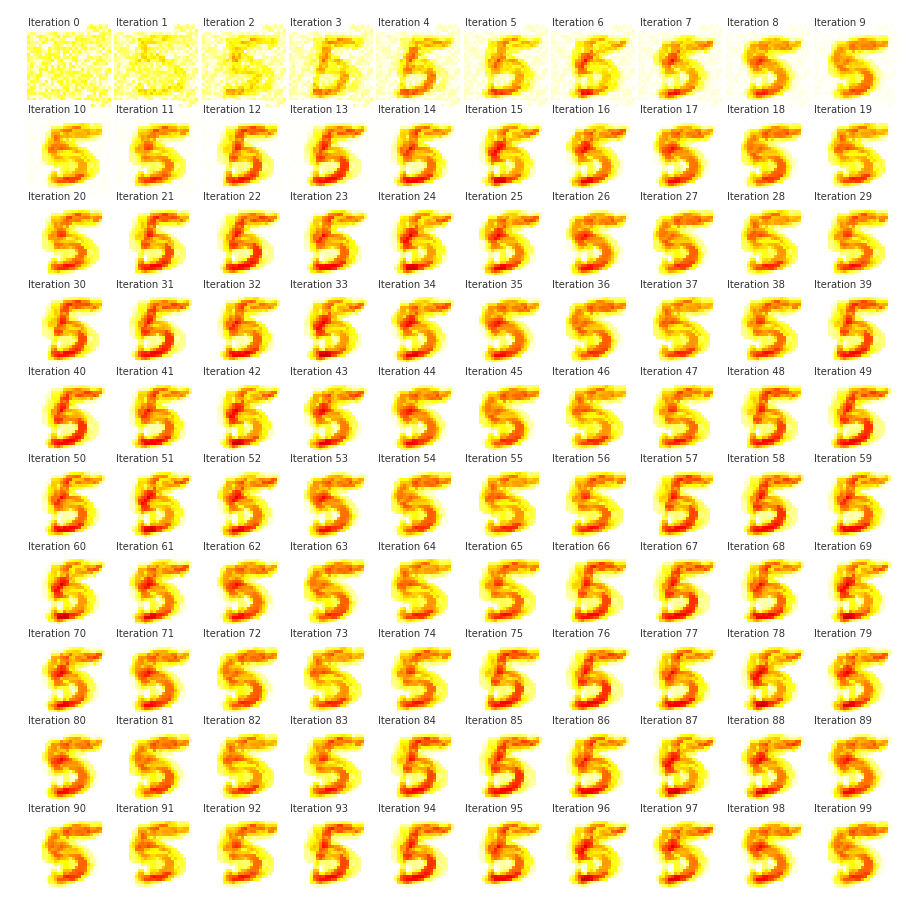

In [22]:
fig = plt.figure(1, figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(iter_sqrt, iter_sqrt), axes_pad=0.05)
for idx in range(len(weights)):
    ax = grid[idx]
    ax.matshow(weights[idx].reshape([28, 28]), cmap='hot_r', vmin=0, vmax=1)
    ax.axis('off')
    
    ax.text(0, 0, 'Iteration %d' % idx, color='k', backgroundcolor='w', alpha=0.8)

To learn more about machine learning with spiking neural networks, check out my [`spiketorch` replication code](https://github.com/djsaunde/spiketorch/blob/master/examples/eth.py) for the architecture described in [Unsupervised learning of digit recognition using spike-timing-dependent plasticity](https://www.frontiersin.org/articles/10.3389/fncom.2015.00099/full#). Also, there are other network experimentation scripts in the [examples directory](https://github.com/djsaunde/spiketorch/blob/master/examples), the efforts of on-going research in the BINDS lab.